<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Indicator" data-toc-modified-id="Indicator-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Indicator</a></span></li><li><span><a href="#Dataloader" data-toc-modified-id="Dataloader-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataloader</a></span></li><li><span><a href="#generate-surface-data" data-toc-modified-id="generate-surface-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>generate surface data</a></span></li></ul></div>

# Indicator

In [1]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
class Indicator:
    def __init__(self):
        self.y_true=[]
        self.y_pred=[]
        
    def indicator_cls(self):
        tn, fp, fn, tp=confusion_matrix(self.y_true,self.y_pred ).ravel()
        POD=tp/(tp+fn)
        FAR=fp/(tp+fp)
        CSI=tp/(tp+fn+fp)
        return {'POD':POD,'FAR':FAR,'CSI':CSI}
    
    def indicator_reg(self):
        conv=np.cov([self.y_true,self.y_pred])
        CC=conv[0,1]/np.sqrt(conv[0,0]*conv[1,1])
        BIAS=np.sum(np.array(self.y_pred)-np.array(self.y_true))/np.sum(self.y_true)
        MSE=np.mean((np.array(self.y_pred)-np.array(self.y_true))**2)
        return {'CC':CC,'BIAS':BIAS,'MSE':MSE}
    
    def reset(self):
        self.y_true=[]
        self.y_pred=[]

In [3]:
indicator=Indicator()

y_true=np.array([0,1,0,1])
y_pred=np.array([0,0,0,1])
indicator.y_true.extend(y_true.tolist())
indicator.y_pred.extend(y_pred.tolist())
print(indicator.indicator_cls())
indicator.reset()

y_true=np.random.rand(10)
y_pred=np.random.rand(10)
indicator.y_true.extend(y_true.tolist())
indicator.y_pred.extend(y_pred.tolist())
print(indicator.indicator_reg())

{'POD': 0.5, 'FAR': 0.0, 'CSI': 0.5}
{'CC': 0.5219991862216652, 'BIAS': -0.16938088345983845, 'MSE': 0.08807572443283634}


# Dataloader

In [7]:
from torch.utils.data import Dataset
from datetime import date
from datetime import timedelta
import numpy as np
import random
import tqdm
import os

GOSE=np.load('/usr/commondata/weather/dataset_release/IR_dataset_QingHua/X_train_hourly.npz')
StageIV=np.load('/usr/commondata/weather/dataset_release/IR_dataset_QingHua/Y_train_hourly.npz')
GOSE=GOSE['arr_0']
StageIV=StageIV['arr_0']

# generate surface data

In [8]:
import torch
import numpy as np
import random

def SetSeed(seed):
    """function used to set a random seed
    Arguments:
        seed {int} -- seed number, will set to torch, random and numpy
    """
    SEED = seed
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    random.seed(SEED)
    np.random.seed(SEED)

SetSeed(2020)

In [3]:
from models.IPEC_model import IPECNet
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from collections import OrderedDict

In [4]:
import models.Dataloader as DL
import imp
imp.reload(DL)

def test_model(model_path,X,Y,multi_gpu=True,batch_size=1024,step=14):
    ########################load model######################
    model=IPECNet(nc=[1,16,16,32,32],padding_type='zero',norm_layer=nn.BatchNorm2d,task='identification')
    model = torch.nn.DataParallel(model.to('cuda'), device_ids=[0,1,2,3])
    state_dict = torch.load(model_path)['state_dict']
    if multi_gpu:
        model.load_state_dict(state_dict)
    else:
        state_dict = torch.load(model_path)['state_dict']
        # create new OrderedDict that does not contain `module.`
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v

        model.load_state_dict(new_state_dict)
        
    model=model.cuda()
    
    
    #######################generate samples################
    L=len(range(14,375-15,step))**2
    test_data=torch.zeros(L,3,29,29)
    y_true=np.zeros(L)

    N=0
    for i in range(14,375-15,step):
        for j in range(14,375-15,step):
            tmpX=DL.IRDataset.unsafe_crop_center(X,i,j,14,14)
            test_data[N,:,:,:]=tmpX
            y_true[N]=(Y[i,j]>0.1)
            N+=1
    
    #######################get pred###################
    with torch.no_grad():
        pred=[]
        for i in range(0,L//batch_size+1):
            scope=range(i*batch_size,min((i+1)*batch_size,L))
            tmpX=torch.tensor(test_data[scope]).float().cuda()
            tmp_pred=np.argmax(model(tmpX).detach().cpu().numpy(),axis=1)
            pred.append(tmp_pred)

    pred=np.hstack(pred)
    
    return pred,y_true

/opt/anaconda3/envs/climate/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


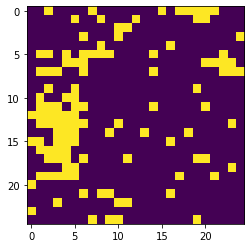

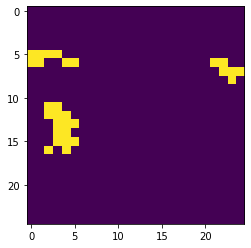

In [22]:
X=torch.tensor(GOSE[88]).float().cuda()
Y=StageIV[88]
pred,y_true=test_model('./results/Epoch_66.pth.tar',X=X,Y=Y,step=14)

plt.imshow(pred.reshape(25,25))
plt.show()

plt.imshow(y_true.reshape(25,25))
plt.show()

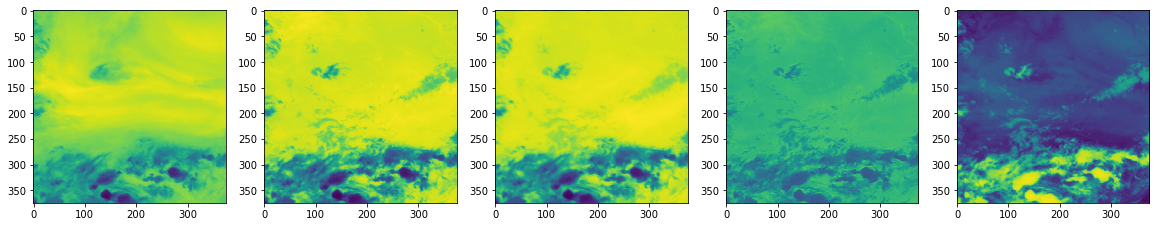

In [21]:
fig=plt.figure(figsize=(20, 4))
plt.subplot(1,5,1)
plt.imshow(X[0].detach().cpu().numpy())
plt.subplot(1,5,2)
plt.imshow(X[1].detach().cpu().numpy())
plt.subplot(1,5,3)
plt.imshow(X[2].detach().cpu().numpy())
plt.subplot(1,5,4)
plt.imshow(X[1].detach().cpu().numpy()-X[2].detach().cpu().numpy())
plt.subplot(1,5,5)
plt.imshow(X[0].detach().cpu().numpy()-X[1].detach().cpu().numpy())
plt.show()

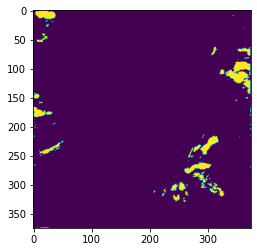

In [150]:
plt.imshow(Y>0.1)